# Predictions by Month

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import RocCurveDisplay

In [2]:
df = pd.read_csv('db_criminalBehaviour_byMonth.csv')
df.drop(['categories', 'Unnamed: 0', 'index'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3677 entries, 0 to 3676
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            3677 non-null   int64 
 1   month           3677 non-null   int64 
 2   problem_type_1  3677 non-null   object
 3   count           3677 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.0+ KB


In [3]:
target = df['count']
train_data = df.drop(['count'], axis=1)

In [4]:
num_features = ['year', 'month']
cat_features = ['problem_type_1']

In [5]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=4)),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

In [6]:
models2test = [
    SVR(),
    DecisionTreeRegressor(max_depth=2, random_state=4392),
    ExtraTreesRegressor(n_estimators=100, random_state=4392),
    GradientBoostingRegressor(random_state=4392),
]

In [7]:
scores_classif = {}
for classifier in models2test:
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])


    stratKFold = TimeSeriesSplit(n_splits=5)
    scores = cross_validate(pipeline, train_data, target, cv=stratKFold,
                            scoring=('r2', 'neg_mean_absolute_error', 'explained_variance'),
                            return_train_score=True, return_estimator=True, return_indices=True) 
    
    print('\n')
    print('-----------------------------------')
    print(str(classifier))
    print('-----------------------------------')

    print('\n')
    print('train_r2 mean: ',scores['train_r2'].mean())
    print('train_r2 std: ',scores['train_r2'].std())
    print('test_r2 mean: ',scores['test_r2'].mean())
    print('test_r2 std: ',scores['test_r2'].std())

    print('\n')
    print('train_neg_mean_absolute_error mean: ',scores['train_neg_mean_absolute_error'].mean())
    print('train_neg_mean_absolute_error std: ',scores['train_neg_mean_absolute_error'].std())
    print('test_neg_mean_absolute_error mean: ',scores['test_neg_mean_absolute_error'].mean())
    print('test_neg_mean_absolute_error std: ',scores['test_neg_mean_absolute_error'].std())

    print('\n')
    print('train_explained_variance mean: ',scores['train_explained_variance'].mean())
    print('train_explained_variance std: ',scores['train_explained_variance'].std())
    print('test_explained_variance mean: ',scores['test_explained_variance'].mean())
    print('test_explained_variance std: ',scores['test_explained_variance'].std())

    clf_txt = str(classifier).split('(')[0]
    scores_classif[clf_txt] = scores



-----------------------------------
SVR()
-----------------------------------


train_r2 mean:  0.1694173682337639
train_r2 std:  0.10939977811939255
test_r2 mean:  -0.0516907000256992
test_r2 std:  0.10148916716802807


train_neg_mean_absolute_error mean:  -13.691811337023523
train_neg_mean_absolute_error std:  1.1678289604906091
test_neg_mean_absolute_error mean:  -21.744710119853227
test_neg_mean_absolute_error std:  2.131432154651629


train_explained_variance mean:  0.28608481176464495
train_explained_variance std:  0.08124452722395839
test_explained_variance mean:  0.14344404930563098
test_explained_variance std:  0.09814220785719031


-----------------------------------
DecisionTreeRegressor(max_depth=2, random_state=4392)
-----------------------------------


train_r2 mean:  0.6336904015502199
train_r2 std:  0.054770090018380325
test_r2 mean:  0.35946062364838516
test_r2 std:  0.15217326175240478


train_neg_mean_absolute_error mean:  -15.454321405156884
train_neg_mean_absolu

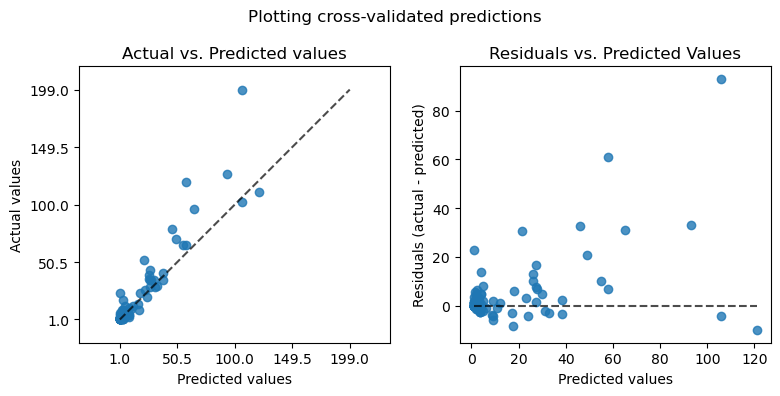

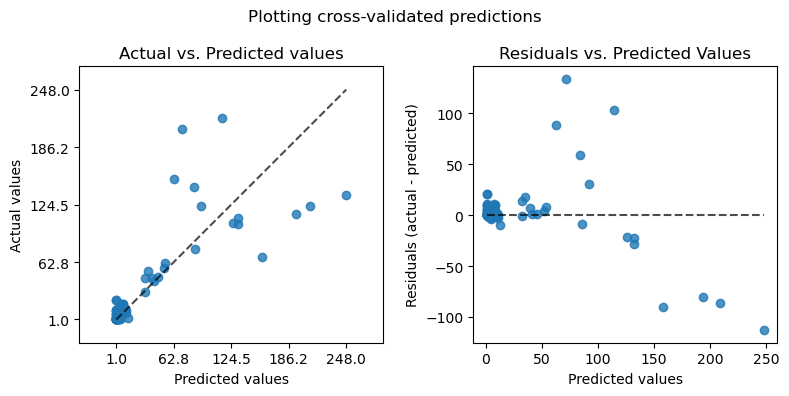

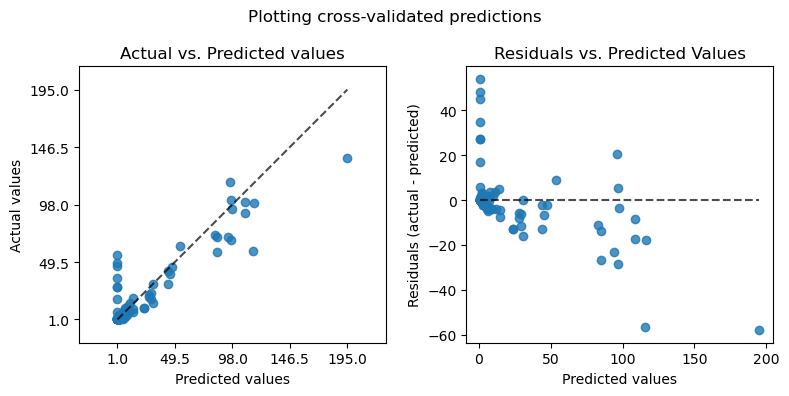

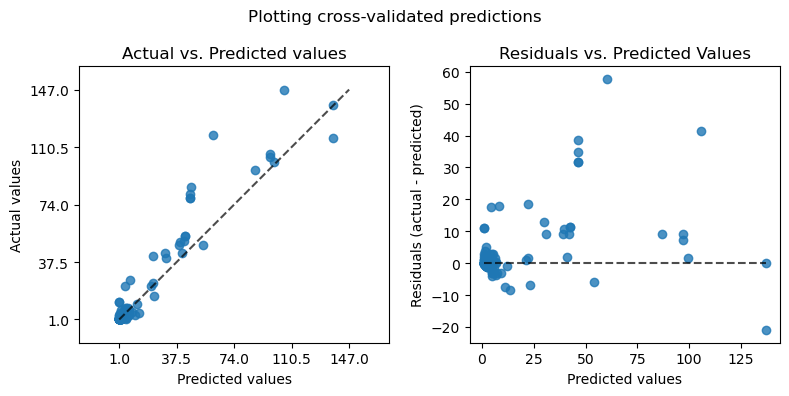

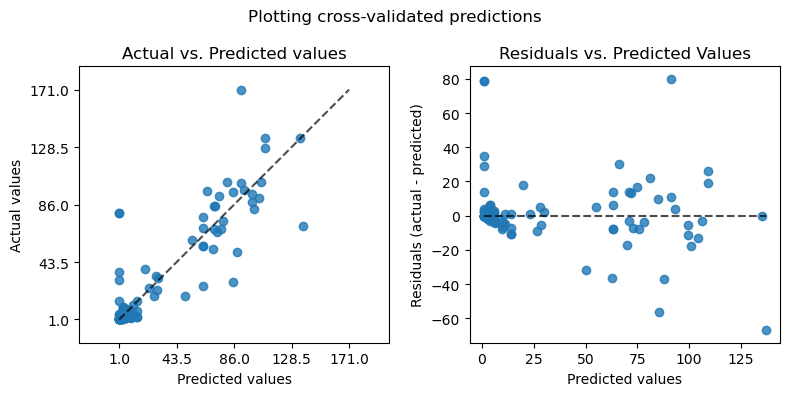

In [8]:
for idx,clf in enumerate(scores_classif['ExtraTreesRegressor']['estimator']):
    idx_train = scores_classif['ExtraTreesRegressor']['indices']['train'][idx]
    idx_test  = scores_classif['ExtraTreesRegressor']['indices']['test'][idx]

    X_train = train_data.loc[idx_train,:]
    y_train = target.loc[idx_train]
    X_test  = train_data.loc[idx_test,:]
    y_test  = target.loc[idx_test]

    y_pred = clf.fit(X_train,y_train).predict(X_test)

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=100,
        ax=axs[0],
        random_state=0,
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=100,
        ax=axs[1],
        random_state=0,
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting cross-validated predictions")
    plt.tight_layout()
    plt.show()

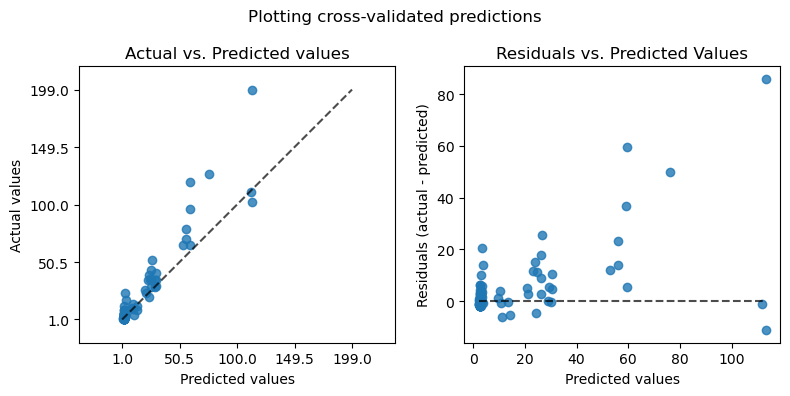

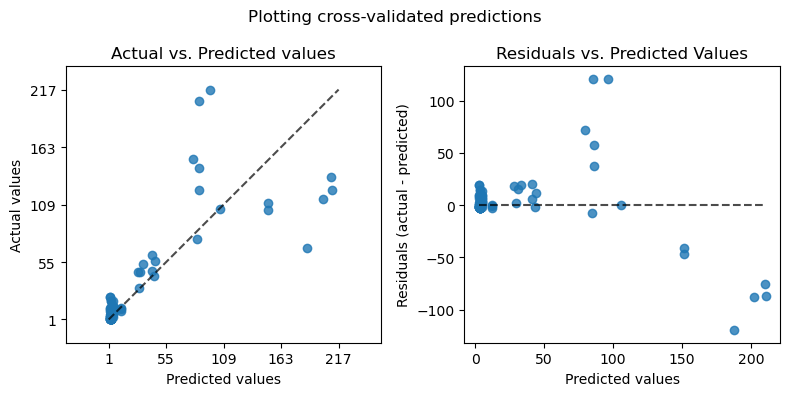

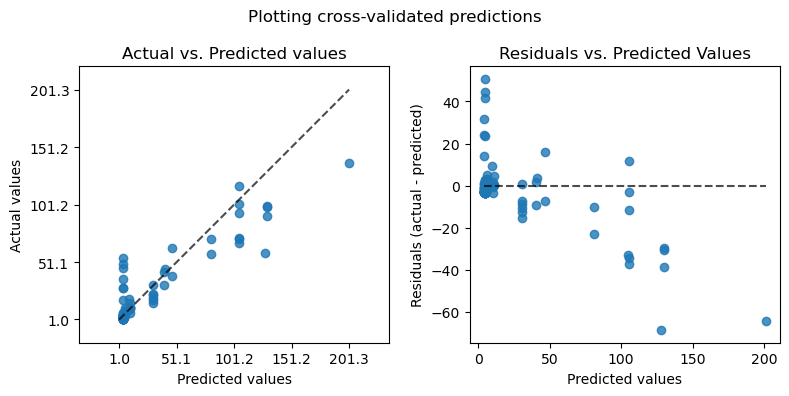

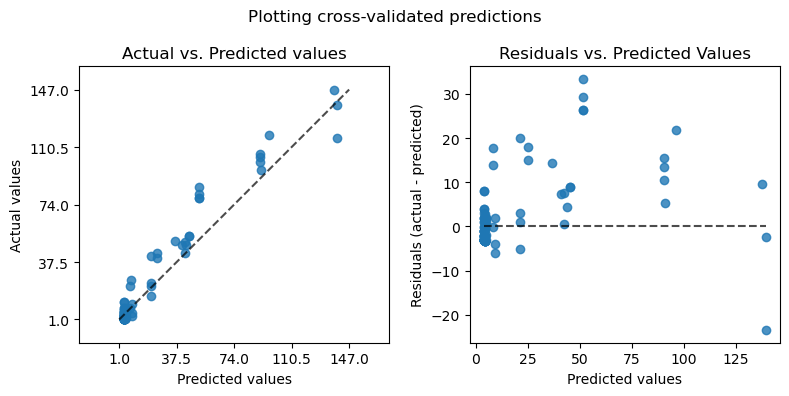

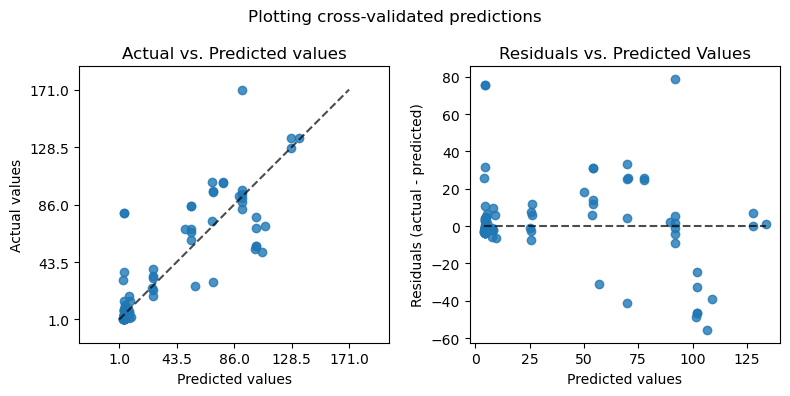

In [9]:
for idx,clf in enumerate(scores_classif['GradientBoostingRegressor']['estimator']):
    idx_train = scores_classif['GradientBoostingRegressor']['indices']['train'][idx]
    idx_test  = scores_classif['GradientBoostingRegressor']['indices']['test'][idx]

    X_train = train_data.loc[idx_train,:]
    y_train = target.loc[idx_train]
    X_test  = train_data.loc[idx_test,:]
    y_test  = target.loc[idx_test]

    y_pred = clf.fit(X_train,y_train).predict(X_test)

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=100,
        ax=axs[0],
        random_state=0,
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=100,
        ax=axs[1],
        random_state=0,
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting cross-validated predictions")
    plt.tight_layout()
    plt.show()